# Homework 2

## FINM 37400 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.decomposition import PCA
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import datetime

In [42]:
file_path = '../data/treasury_ts_2015-08-15.xlsx'
df = pd.read_excel(file_path, sheet_name='database')
df["tdduratn"] = df["tdduratn"] / 365.25
df["tdyld"] = df["tdyld"] * 365.25
df.head()

,kytreasno,kycrspid,caldt,tdbid,tdask,tdnomprc,tdnomprc_flg,tdsourcr,tdaccint,tdretnua,tdyld,tdduratn,tdpubout,tdtotout,tdpdint,tdidxratio,tdidxratio_flg
0,204046,2.015082e+07,1989-05-02,116.06250,116.31250,116.18750,M,R,2.230663,0.005823,0.088092,10.028647,6470.0,7150.0,0.0,NaN,NaN
1,204046,2.015082e+07,1989-05-03,116.18750,116.43750,116.31250,M,R,2.260014,0.001303,0.087986,10.032864,6470.0,7150.0,0.0,NaN,NaN
2,204046,2.015082e+07,1989-05-04,115.59375,115.84375,115.71875,M,R,2.289365,-0.004760,0.088487,9.997273,6470.0,7150.0,0.0,NaN,NaN
3,204046,2.015082e+07,1989-05-05,116.21875,116.46875,116.34375,M,R,2.318715,0.005545,0.087959,10.029201,6470.0,7150.0,0.0,NaN,NaN
4,204046,2.015082e+07,1989-05-08,115.71875,115.96875,115.84375,M,R,2.406768,-0.003472,0.088378,9.993429,6470.0,7150.0,0.0,NaN,NaN


# 1 HBS Case: Fixed-Income Arbitrage in a Financial Crisis (A): US Treasuries in November 2008

## Data
* Use the data file `treasury_ts_2015-08-15.xlsx`.
* Examine the treasure issues with `kytreasno` of `204046` and `204047`. These are the bond and note (respectively) which mature on 2015-08-15.
* Look at the data on 2008-11-04.

## 1.1 The situation

Make a chart comparing the issues in the following features, (as of Nov 4, 2008.)
* coupon rate
* bid
* ask
* accrued interest
* dirty price
* duration (quoted in years, not days, assuming 365.25 days per year.)
* modified duration
* YTM

## 1.2 Hedge Ratio

Suppose you are building a trade to go long $n_i$ bonds (`204046`) and short $n_j$ notes (`204047`).

We can find an equation for $n_j$ in terms of $n_i$ such that the total holdings will have duration equal to zero. (Having zero duration also means have zero dollar duration, if helpful.)

Notation:
* $n_i$: number of bonds purchased (or sold)
* $D_i$: duration of bond $i$
* $D_{\$,i}$: dollar duration of bond $i$, equal to $p_iD_i$

If we want the total duration of our holdings to be zero, then we need to size the trade such that $n_i$ and $n_j$ satisfy,

$$0 = n_iD_{\$,i} + n_jD_{\$,j}$$

$$n_j = -n_i\frac{D_{\$,i}}{D_{\$,j}}$$

Suppose you will use \\$1mm of capital, leveraged 50x to buy \\$50mm of the bonds (`204046`).

Use the ratio above to short a number of notes (`204047`) to keep zero duration.

Report the number of bonds and notes of your position, along with the total dollars in the short position.

In [59]:
# 1.1
def filter_and_transform_data(df, selected_ids, date):
    df_selected = df[(df["kytreasno"].isin(selected_ids)) & (df["caldt"] == date)].set_index("kytreasno")
    df_selected["tdcouprt"] = [4.25, 10.625]  # Hardcoded values (Values in a different sheet)
    situation = df_selected.loc[:, ["tdcouprt", "tdbid", "tdask", "tdaccint", "tdnomprc", "tdduratn", "tdyld"]].rename(
        columns={
            "tdcouprt": "Coupon Rate",
            "tdbid": "Bid",
            "tdask": "Ask",
            "tdaccint": "Accrued Interest",
            "tdnomprc": "Clean Price",
            "tdduratn": "Duration",
            "tdyld": "YTM"
        }
    )

    situation["Dirty Price"] = situation["Clean Price"] + situation["Accrued Interest"]
    situation["Modified Duration"] = situation["Duration"] / (1 + situation["YTM"] / 2)
    return situation

selected_ids = [204046, 204047]
situation = filter_and_transform_data(df, selected_ids, date="2008-11-04")
situation.T

kytreasno,204047,204046
Coupon Rate,4.250000,10.625000
Bid,105.953125,141.859375
Ask,105.984375,141.890625
Accrued Interest,0.935462,2.338655
Clean Price,105.968750,141.875000
Duration,5.935706,5.230138
YTM,0.032362,0.035753
Dirty Price,106.904212,144.213655
Modified Duration,5.841189,5.138284


In [60]:
# 1.2
def calculate_hedge_ratio(df, capital_used, leverage, amount_invested, long_bond_id, short_bond_id):
    clean_price_i = df.loc[long_bond_id, "Clean Price"]
    duration_i = df.loc[long_bond_id, "Duration"]
    clean_price_j = df.loc[short_bond_id, "Clean Price"]
    duration_j = df.loc[short_bond_id, "Duration"]

    n_i = amount_invested / clean_price_i
    D_s_i = clean_price_i * duration_i
    D_s_j = clean_price_j * duration_j
    n_j = -n_i * (D_s_i / D_s_j)

    total_short_position = n_j * clean_price_j

    final_df = pd.DataFrame({
        "Investment": [amount_invested, total_short_position],
        "Price": [clean_price_i, clean_price_j],
        "Number of Holdings": [n_i, n_j],
        "Duration": [duration_i, duration_j],
        "Dollar Duration": [D_s_i, D_s_j],
        "Modified Duration": [df.loc[long_bond_id, "Modified Duration"], df.loc[short_bond_id, "Modified Duration"]]
    }, index=[long_bond_id, short_bond_id])

    return final_df


capital_used = 1_000_000
leverage = 50
amount_invested = 50_000_000
long_bond_id = 204046
short_bond_id = 204047

hedge_df = calculate_hedge_ratio(situation, capital_used, leverage, amount_invested, long_bond_id, short_bond_id)
hedge_df.T

,204046,204047
Investment,5.000000e+07,-4.405658e+07
Price,1.418750e+02,1.059688e+02
Number of Holdings,3.524229e+05,-4.157507e+05
Duration,5.230138e+00,5.935706e+00
Dollar Duration,7.420258e+02,6.289993e+02
Modified Duration,5.138284e+00,5.841189e+00


## 1.3 Profit Opportunity

Using the concept of **modified duration**, how much profit or loss (PnL) would you expect to make for every basis point of convergence in the spread? Specifically, assume the convergence is symmetric: the bond's (`204046`) ytm goes down 0.5bp and the note (`204047`) ytm goes up 0.5bp.

Describe the PnL you would expect to achieve on your position should this happen. Specify the PnL of the long position, the short position, and the net total.

Suppose the spread in YTM between the two securities disappears, due to a symmetric move of roughly ~17bps in each security's YTM. What is the PnL? (This is just a linearly scaling of your prior answer for a 1bp convergence.) 


## 1.4 Result in 2008

Calculate the profit (or loss) on the position on the following two dates:
* 2008-11-25
* 2008-12-16

To calculate the pnl on each date, simply use the prices of the securities on those dates along with your position sizes, ($n_i, n_j$). No coupon is being paid in November or December, so all you need is the "dirty" price on these two dates.

Does the pnl make sense (approximately) given your results in 1.3 with regard to the sensitivity of pnl to moves in the YTM spread?

## 1.5 Examining the Trade through June 2009

Calculate the pnl of the trade for the following dates:
* 2009-01-27
* 2009-03-24
* 2009-06-16

Did the trade do well or poorly in the first six months of 2009?

Calculate the YTM spreads on these dates. Does the YTM spread correspond to pnl roughly as we would expect based on the calculation in 1.3?

In [137]:
# 1.3
def calculate_pnl(df, long_bond_id, short_bond_id, n_i, n_j, ytm_change_bp):
    ytm_change = ytm_change_bp / 10_000
    mod_duration_i = df.loc[long_bond_id, "Modified Duration"]
    mod_duration_j = df.loc[short_bond_id, "Modified Duration"]

    price_change_i = -mod_duration_i * ytm_change * df.loc[long_bond_id, "Dirty Price"]
    price_change_j = -mod_duration_j * ytm_change * df.loc[short_bond_id, "Dirty Price"]

    pnl_long = n_i * price_change_i
    pnl_short = n_j * price_change_j
    net_pnl = pnl_long + pnl_short

    pnl_df = pd.DataFrame({
        "PnL": [pnl_long, pnl_short, net_pnl]
    }, index=["Long Position", "Short Position", "Net Total"])
    return pnl_df

In [138]:
n_i = hedge_df.loc[long_bond_id, "Number of Holdings"]
n_j = hedge_df.loc[short_bond_id, "Number of Holdings"]
ytm_change_bp = 0.5  
pnl_df = calculate_pnl(situation, long_bond_id, short_bond_id, n_i, n_j, ytm_change_bp)
pnl_df

,PnL
Long Position,-13057.458140
Short Position,12980.726768
Net Total,-76.731372


In [139]:
ytm_change_bp = 0.17
pnl_df = calculate_pnl(situation, long_bond_id, short_bond_id, n_i, n_j, ytm_change_bp)
pnl_df

,PnL
Long Position,-4439.535767
Short Position,4413.447101
Net Total,-26.088666


### 1.4.1 - 2008-11-25

In [140]:
situation_2 = filter_and_transform_data(df, selected_ids, "2008-11-25")
situation_2.T

kytreasno,204047,204046
Coupon Rate,4.250000,10.625000
Bid,110.796875,145.859375
Ask,110.828125,145.890625
Accrued Interest,1.177989,2.944973
Clean Price,110.812500,145.875000
Duration,5.901686,5.199097
YTM,0.024787,0.030086
Dirty Price,111.990489,148.819973
Modified Duration,5.829439,5.122046


***

# 2 Hedging Duration

Use data from `../data/treasury_ts_duration_2024-10-31.xlsx`.

The file contains time-series information on two treasuries. Observe the info of the securities with the following code:


In [64]:
import pandas as pd

In [65]:
QUOTE_DATE = '2024-10-31'
filepath = f'../data/treasury_ts_duration_{QUOTE_DATE}.xlsx'

data = pd.read_excel(filepath,sheet_name='database')
data_info =  data.drop_duplicates(subset='KYTREASNO', keep='first').set_index('KYTREASNO')
data_info[['type','issue date','maturity date','cpn rate']]

,type,issue date,maturity date,cpn rate
KYTREASNO,,,,
207391,note,2019-08-15,2029-08-15,1.625
207392,bond,2019-08-15,2049-08-15,2.250


You will largely focus on the sheets which give the timeseries of prices and durations for each of the two securities, as shown in the following code.

In [66]:
SHEET_PRICE = 'price'
SHEET_DURATION = 'duration'
INDEX_NAME = 'quote date'

price = pd.read_excel(filepath,sheet_name=SHEET_PRICE).set_index(INDEX_NAME)
duration = pd.read_excel(filepath,sheet_name=SHEET_DURATION).set_index(INDEX_NAME)

display(price)
display(duration)

,207391,207392
quote date,,
2019-08-09,98.882812,99.789062
2019-08-12,99.796875,102.554688
2019-08-13,99.281250,101.867188
2019-08-14,100.406250,105.179688
2019-08-15,100.882812,106.234375
...,...,...
2024-11-22,88.740234,63.722656
2024-11-25,89.287109,65.378906
2024-11-26,89.214844,65.175781


,207391,207392
quote date,,
2019-08-09,9.289497,22.000102
2019-08-12,9.285468,22.118496
2019-08-13,9.280314,22.084308
2019-08-14,9.282750,22.228549
2019-08-15,9.282163,22.270910
...,...,...
2024-11-22,4.539445,17.205511
2024-11-25,4.531983,17.312267
2024-11-26,4.529132,17.295472


### 2.1.

Suppose you have a portfolio of `10,000` USD long in security `207391` on the first day of the sample.

If you want to manage interest rate exposure using duration, how large of a short position should you hold in `207392`?

### 2.2.

Step through the time-series, doing the following:

* Starting at the end of the first day, set the hedged position according to the relative given durations.
* Use the second day's price data to evaluate the net profit or loss of the hedged position.
* Reset the the hedged position using the end-of-second-day durations. Again fix the long position of security `207391` to be `10,000`.
* Repeat throughout the timeseries.

Calculate the daily profit and loss (PnL) for the
* dynamically hedged position constructed above.
* long-only position, (still at `10,000` throughout.)

(You might check to verify that the net duration is zero at all dates.)

Report...
* the cumulative PnL of both strategies via a plot.
* the (daily) mean, standard deviation, min, and max of the PnL in a table.

### 2.3.

Give two reasons that the daily PnL is not always zero for the hedged position given that we have perfectly hedged the duration.

### 2.4.
The PnL above doesn't account for the coupons.

Calculate a dataframe indexed by dates with columns for the two treasuries with values of coupon payments. 
* Recall that the stated coupon rate is semiannual, so at any give coupon date, it pays half the stated rate.
* Figure out the coupon dates by using the `data` tab and looking for dates where `acc int` goes down. Recall that accrued interest measures the portion of the coupon period that has passed. So when this resets, it is because the coupon has been paid.

Report the first 5 dates that a coupon is paid (by either bond).

### 2.5.
Account for the coupons in the PnL calculations of `2.2`. Report the updated PnL in a plot and a table, similar to the reporting in `2.2`.

In [134]:
# 2.1
first_date = price.index[0]
price_note = price.loc[first_date, 207391]
price_bond = price.loc[first_date, 207392]
duration_note = duration.loc[first_date, 207391]
duration_bond = duration.loc[first_date, 207392]

portfolio_value = 10000  
dollar_duration_long = portfolio_value * duration_note
notional_short = dollar_duration_long / duration_bond
units_short = notional_short / price_bond

print(f"Notional Short Position in Bond 207392 on {first_date.date()}: ${notional_short}")
print(f"Units to Short in Bond 207392 on {first_date.date()}: {units_short}")

Notional Short Position in Bond 207392 on 2019-08-09: $4222.479082922904
Units to Short in Bond 207392 on 2019-08-09: 42.31404702216642


In [119]:
# 2.2
def rebalance_positions(price_row, duration_row, portfolio_value):
    price_207391 = price_row[207391]
    duration_207391 = duration_row[207391]
    long_units = portfolio_value / price_207391
    
    price_207392 = price_row[207392]
    duration_207392 = duration_row[207392]
    notional_short = portfolio_value * (duration_207391 / duration_207392)
    short_units = notional_short / price_207392
    
    dollar_duration_long = portfolio_value * duration_207391
    dollar_duration_short = notional_short * duration_207392
    net_duration = dollar_duration_long - dollar_duration_short  
    
    return {
        'long_units': long_units,
        'short_units': short_units,
        'net_duration': net_duration
    }

def compute_daily_price_pnl(price_today, price_next, positions):
    pnl_long = positions['long_units'] * (price_next[207391] - price_today[207391])
    pnl_short = - positions['short_units'] * (price_next[207392] - price_today[207392])
    return pnl_long + pnl_short

def simulate_strategies(price_df, duration_df, portfolio_value):
    dates = price_df.index.sort_values()
    num_periods = len(dates) - 1
    
    pnl_dynamic_list, pnl_long_only_list, pnl_dates = [], [], []
    
    for i in range(num_periods):
        date_t = dates[i]
        date_next = dates[i+1]
        
        price_today = price_df.loc[date_t]
        duration_today = duration_df.loc[date_t]
        pos = rebalance_positions(price_today, duration_today, portfolio_value)
        price_next_day = price_df.loc[date_next]
        daily_pnl_dynamic = compute_daily_price_pnl(price_today, price_next_day, pos)
        pnl_dynamic_list.append(daily_pnl_dynamic)
        long_units = portfolio_value / price_today[207391]
        daily_pnl_long = long_units * (price_next_day[207391] - price_today[207391])
        pnl_long_only_list.append(daily_pnl_long)
        pnl_dates.append(date_next)
    
    pnl_dynamic_series = pd.Series(pnl_dynamic_list, index=pnl_dates)
    pnl_long_only_series = pd.Series(pnl_long_only_list, index=pnl_dates)
    
    return pnl_dynamic_series, pnl_long_only_series

portfolio_value = 10000.0
pnl_dynamic_series, pnl_long_only_series = simulate_strategies(price, duration, portfolio_value)
display(pnl_dynamic_series.to_frame().rename(columns = {0: "PnL Dynamic Series"}))
display(pnl_long_only_series.to_frame().rename(columns = {0: "PnL Long Only Series"}))

,PnL Dynamic Series
2019-08-12,-24.585820
2019-08-13,-23.524773
2019-08-14,-23.332664
2019-08-15,5.588175
2019-08-16,33.309442
...,...
2024-11-22,-4.642675
2024-11-25,-6.948725
2024-11-26,0.039551
2024-11-27,5.652675


,PnL Long Only Series
2019-08-12,92.438967
2019-08-13,-51.667450
2019-08-14,113.314448
2019-08-15,47.463430
2019-08-16,-24.006815
...,...
2024-11-22,-1.320393
2024-11-25,61.626499
2024-11-26,-8.093621
2024-11-27,24.957304


In [120]:
cum_pnl_dynamic = pnl_dynamic_series.cumsum()
cum_pnl_long_only = pnl_long_only_series.cumsum()
display(cum_pnl_dynamic.to_frame().rename(columns = {0: "Cumulative PnL Dynamic Series"}))
display(cum_pnl_long_only.to_frame().rename(columns = {0: "Cumulative PnL Long Only Series"}))

,Cumulative PnL Dynamic Series
2019-08-12,-24.585820
2019-08-13,-48.110593
2019-08-14,-71.443256
2019-08-15,-65.855082
2019-08-16,-32.545640
...,...
2024-11-22,76.656298
2024-11-25,69.707573
2024-11-26,69.747124
2024-11-27,75.399799


,Cumulative PnL Long Only Series
2019-08-12,92.438967
2019-08-13,40.771517
2019-08-14,154.085965
2019-08-15,201.549394
2019-08-16,177.542580
...,...
2024-11-22,-950.480990
2024-11-25,-888.854491
2024-11-26,-896.948112
2024-11-27,-871.990808


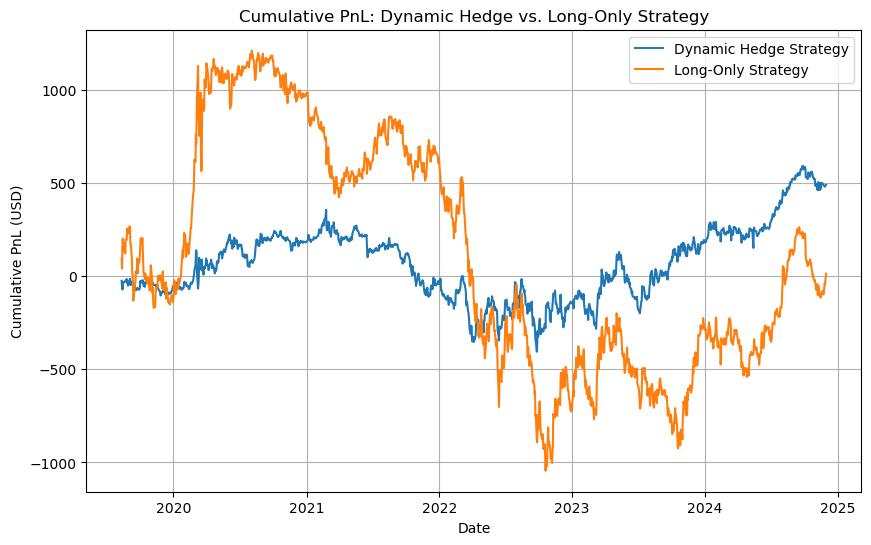

In [136]:
plt.figure(figsize=(10, 6))
plt.plot(cum_pnl_dynamic.index, cum_pnl_dynamic, label='Dynamic Hedge Strategy')
plt.plot(cum_pnl_long_only.index, cum_pnl_long_only, label='Long-Only Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL (USD)')
plt.title('Cumulative PnL: Dynamic Hedge vs. Long-Only Strategy')
plt.legend()
plt.grid(True)
plt.show()

In [122]:
pnl_stats = pd.DataFrame({
    'Strategy': ['Dynamic Hedge', 'Long Only'],
    'Mean': [pnl_dynamic_series.mean(), pnl_long_only_series.mean()],
    'Std': [pnl_dynamic_series.std(), pnl_long_only_series.std()],
    'Min': [pnl_dynamic_series.min(), pnl_long_only_series.min()],
    'Max': [pnl_dynamic_series.max(), pnl_long_only_series.max()]
})
pnl_stats.set_index("Strategy").T

Strategy,Dynamic Hedge,Long Only
Mean,0.059955,-0.631149
Std,21.090467,44.589519
Min,-98.341110,-321.203791
Max,118.431025,276.272207


### 2.3
- Convexity Effects: The duration hedge offsets only the first-order (linear) sensitivity to interest rate changes. Residual nonlinearity (convexity) in price-yield curves can generate gains or losses.
- Timing & Rebalancing Gaps: The hedge is reset discretely, not continuously. Intraday price movements and yield changes can lead to temporary mismatches.

In [133]:
# 2.4
file_path = '../data/treasury_ts_duration_2024-10-31.xlsx'
df_data = pd.read_excel(file_path, sheet_name='database')
df_data

,KYTREASNO,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm,duration
0,207391,note,2023-08-09,2019-08-15,2029-08-15,6.017796,0.966851,1.625,87.039062,87.085938,87.062500,0.785566,87.848066,0.040701,5.686497
1,207391,note,2023-08-16,2019-08-15,2029-08-15,5.998631,0.005435,1.625,85.703125,85.750000,85.726562,0.004416,85.730978,0.043538,5.717357
2,207391,note,2023-08-15,2019-08-15,2029-08-15,6.001369,0.000000,1.625,85.851562,85.875000,85.863281,0.000000,85.863281,0.043241,5.720397
3,207391,note,2023-08-14,2019-08-15,2029-08-15,6.004107,0.994475,1.625,86.000000,86.023438,86.011719,0.808011,86.819730,0.042921,5.669930
4,207391,note,2023-08-11,2019-08-15,2029-08-15,6.012320,0.977901,1.625,86.179688,86.226562,86.203125,0.794544,86.997669,0.042490,5.678708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2656,207392,bond,2020-01-22,2019-08-15,2049-08-15,29.563313,0.869565,2.250,100.570312,100.632812,100.601562,0.978261,101.579823,0.022222,21.581604
2657,207392,bond,2020-01-21,2019-08-15,2049-08-15,29.566051,0.864130,2.250,100.257812,100.320312,100.289062,0.972147,101.261209,0.022367,21.569617
2658,207392,bond,2020-01-17,2019-08-15,2049-08-15,29.577002,0.842391,2.250,99.281250,99.343750,99.312500,0.947690,100.260190,0.022822,21.534099
2659,207392,bond,2020-01-15,2019-08-15,2049-08-15,29.582478,0.831522,2.250,100.242188,100.304688,100.273438,0.935462,101.208899,0.022374,21.585332


In [124]:
def get_coupon_payments_for_treasury(df, treasury_id):
    treasury_df = df[df['KYTREASNO'] == treasury_id].sort_values(by='quote date').copy()
    treasury_df.reset_index(drop=True, inplace=True)
    treasury_df['coupon_payment'] = 0.0
    for i in range(1, len(treasury_df)):
        if treasury_df.loc[i, 'accrued int'] < treasury_df.loc[i-1, 'accrued int']:
            treasury_df.loc[i, 'coupon_payment'] = treasury_df.loc[i, 'cpn rate'] / 2.0
    treasury_df.set_index('quote date', inplace=True)
    return treasury_df[['coupon_payment']]

def combine_coupon_payments(df, treasury_ids):
    coupon_dfs = []
    for tid in treasury_ids:
        cp_df = get_coupon_payments_for_treasury(df, tid)
        cp_df = cp_df.rename(columns={'coupon_payment': tid})
        coupon_dfs.append(cp_df)
    coupon_payments = pd.concat(coupon_dfs, axis=1).fillna(0)
    coupon_payments.sort_index(inplace=True)    
    return coupon_payments
    
treasury_ids = [207391, 207392]
coupon_payments_df = combine_coupon_payments(df_data, treasury_ids)
coupon_dates = coupon_payments_df[(coupon_payments_df[treasury_ids[0]] > 0) | 
                                  (coupon_payments_df[treasury_ids[1]] > 0)]
coupon_dates.head()

,207391,207392
quote date,,
2020-02-18,0.8125,1.125
2020-08-17,0.8125,1.125
2021-02-16,0.8125,1.125
2021-08-16,0.8125,1.125
2022-02-15,0.8125,1.125


In [125]:
# 2.5

def compute_coupon_pnl(date, positions, coupon_df):
    coupon_long = coupon_df.at[date, 207391] if date in coupon_df.index else 0.0
    coupon_short = coupon_df.at[date, 207392] if date in coupon_df.index else 0.0
    return coupon_long, coupon_short

def simulate_strategies_with_coupons(price_df, duration_df, coupon_df, portfolio_value):
    dates = price_df.index.sort_values()
    num_periods = len(dates) - 1
    pnl_dynamic_list = []
    pnl_long_only_list = []
    pnl_dates = []
    
    for i in range(num_periods):
        date_t = dates[i]
        date_next = dates[i+1]
        price_today = price_df.loc[date_t]
        duration_today = duration_df.loc[date_t]
        
        positions = rebalance_positions(price_today, duration_today, portfolio_value)
        price_next_day = price_df.loc[date_next]
        pnl_price = compute_daily_price_pnl(price_today, price_next_day, positions)
        long_units_long_only = portfolio_value / price_today[207391]
        pnl_long_only_price = long_units_long_only * (price_next_day[207391] - price_today[207391])
        
        coupon_long, coupon_short = compute_coupon_pnl(date_next, positions, coupon_df)
        pnl_coupon_dynamic = positions['long_units'] * coupon_long - positions['short_units'] * coupon_short
        pnl_coupon_long_only = long_units_long_only * coupon_long
        pnl_dynamic_total = pnl_price + pnl_coupon_dynamic
        pnl_long_only_total = pnl_long_only_price + pnl_coupon_long_only
        pnl_dynamic_list.append(pnl_dynamic_total)
        pnl_long_only_list.append(pnl_long_only_total)
        pnl_dates.append(date_next)
    
    pnl_dynamic_series = pd.Series(pnl_dynamic_list, index=pnl_dates)
    pnl_long_only_series = pd.Series(pnl_long_only_list, index=pnl_dates)    
    return pnl_dynamic_series, pnl_long_only_series

In [126]:
portfolio_value = 10000.0
pnl_dynamic_series, pnl_long_only_series = simulate_strategies_with_coupons(
    price, duration, coupon_payments_df, portfolio_value
)

display(pnl_dynamic_series.to_frame().rename(columns = {0: "PnL Dynamic Series"}))
display(pnl_long_only_series.to_frame().rename(columns = {0: "PnL Long Only Series"}))

,PnL Dynamic Series
2019-08-12,-24.585820
2019-08-13,-23.524773
2019-08-14,-23.332664
2019-08-15,5.588175
2019-08-16,33.309442
...,...
2024-11-22,-4.642675
2024-11-25,-6.948725
2024-11-26,0.039551
2024-11-27,5.652675


,PnL Long Only Series
2019-08-12,92.438967
2019-08-13,-51.667450
2019-08-14,113.314448
2019-08-15,47.463430
2019-08-16,-24.006815
...,...
2024-11-22,-1.320393
2024-11-25,61.626499
2024-11-26,-8.093621
2024-11-27,24.957304


In [127]:
cum_pnl_dynamic = pnl_dynamic_series.cumsum()
cum_pnl_long_only = pnl_long_only_series.cumsum()
display(cum_pnl_dynamic.to_frame().rename(columns = {0: "Cumulative PnL Dynamic Series"}))
display(cum_pnl_long_only.to_frame().rename(columns = {0: "Cumulative PnL Long Only Series"}))

,Cumulative PnL Dynamic Series
2019-08-12,-24.585820
2019-08-13,-48.110593
2019-08-14,-71.443256
2019-08-15,-65.855082
2019-08-16,-32.545640
...,...
2024-11-22,488.456301
2024-11-25,481.507576
2024-11-26,481.547127
2024-11-27,487.199802


,Cumulative PnL Long Only Series
2019-08-12,92.438967
2019-08-13,40.771517
2019-08-14,154.085965
2019-08-15,201.549394
2019-08-16,177.542580
...,...
2024-11-22,-97.620079
2024-11-25,-35.993580
2024-11-26,-44.087201
2024-11-27,-19.129896


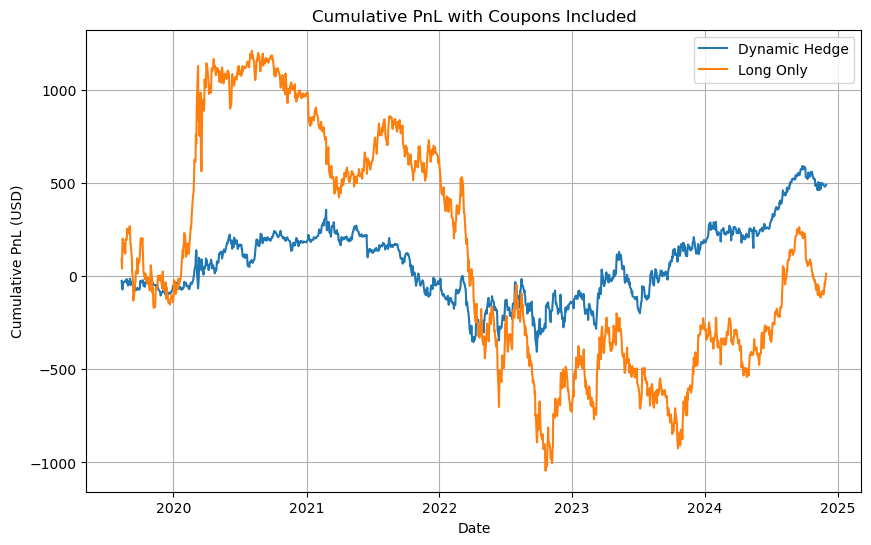

In [135]:
plt.figure(figsize=(10,6))
plt.plot(cum_pnl_dynamic.index, cum_pnl_dynamic, label='Dynamic Hedge')
plt.plot(cum_pnl_long_only.index, cum_pnl_long_only, label='Long Only')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL (USD)')
plt.title('Cumulative PnL with Coupons Included')
plt.legend()
plt.grid(True)
plt.show()

In [132]:
pnl_stats = pd.DataFrame({
    'Strategy': ['Dynamic Hedge', 'Long Only'],
    'Mean': [pnl_dynamic_series.mean(), pnl_long_only_series.mean()],
    'Std': [pnl_dynamic_series.std(), pnl_long_only_series.std()],
    'Min': [pnl_dynamic_series.min(), pnl_long_only_series.min()],
    'Max': [pnl_dynamic_series.max(), pnl_long_only_series.max()]
})
print("\nDaily PnL Statistics (with Coupons):")
pnl_stats.set_index("Strategy")


Daily PnL Statistics (with Coupons):


,Mean,Std,Min,Max
Strategy,,,,
Dynamic Hedge,0.369812,21.419372,-98.341110,118.431025
Long Only,0.010582,45.027555,-321.203791,276.272207


***